In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, train_test_split as tts, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [ ]:
df = pd.read_csv("./german_credit_data 2.csv", index_col=0)
df.head()

In [ ]:
# Check Dataset:

def check_data(dataframe,head=5):
    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe().T)
check_data(df)

In [ ]:
# Check for duplicate rows
duplicated = df[df.duplicated()]

print('Before dropping duplicates:', df.shape[0])
print('Number of duplicate rows:', len(duplicated))

# Check if duplicates have any missing values
dup_nan = duplicated.isnull().sum().sum() == 0
if dup_nan:
    print('No missing values in duplicated rows')
else:
    print('Missing values in duplicated rows')

# Drop duplicates
df.drop_duplicates(inplace=True)
print('After dropping duplicates:', df.shape[0])

In [ ]:
def unique_value(data_set, column_name):
    return data_set[column_name].nunique()

print("Number of the Unique Values:\n",unique_value(df, df.columns))   

In [ ]:
def grab_col_names(dataframe, cat_th=5, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [ ]:
df.describe().T

Target Variable Analysis¶


In [ ]:
df["Risk"].value_counts()

In [ ]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': round(100 * (dataframe[col_name].value_counts()) / len(dataframe), 2)}))

    if plot:
        sns.countplot(x=col_name, data=dataframe)
        plt.show()
        
cat_summary(df, 'Risk', plot=True)

Missing Values¶


In [ ]:
msno.matrix(df)

In [ ]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

Check Outliers¶


In [ ]:
# Lets analyze outliers:

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

for col in num_cols:
    low_limit, up_limit = outlier_thresholds(df, col)
    print(low_limit, up_limit)

Visualizing Categorical Variables

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x='Sex', y='Age', hue='Risk', data=df)

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x='Housing', y='Age', hue='Risk', data=df)

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x='Checking account', y='Credit amount', hue='Risk', data=df)

In [ ]:
def hist_for_nums(data, numeric_cols):
    for col in numeric_cols:
        data[col].plot.hist(alpha=0.5, color='g')
        plt.xlabel(col)
        plt.title(col)
        plt.show()
hist_for_nums(df, num_cols)

In [ ]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


# cat_cols, num_cols, cat_but_car = grab_col_names(df)

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

In [ ]:
 cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)


Analysis of Correlation¶


In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

MACHINE LEARNING MODEL¶


In [ ]:
# X and y variables:

X = df.drop('Risk', axis=1)
y = df["Risk"]

In [ ]:
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [ ]:
# KNN
knn_model = KNeighborsClassifier().fit(X,y)
# y_pred for confusion matrix:
y_pred = knn_model.predict(X)

# y_prob for AUC:
y_prob = knn_model.predict_proba(X)[:,1]
print(classification_report(y, y_pred))

In [ ]:
roc_auc_score(y,y_prob)

In [ ]:
cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Mean Test Accuracy: ",cv_results["test_accuracy"].mean())
print("Mean Test f1 score: ",cv_results["test_f1"].mean())
print("Mean Test roc_auc: ",cv_results["test_roc_auc"].mean())

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.get_params()

In [ ]:
knn_params = {"n_neighbors":range(2,50)}
knn_gs_best = GridSearchCV(knn_model, knn_params, cv=5, n_jobs=-1, verbose=1).fit(X,y)
knn_gs_best.best_params_

In [ ]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X,y)

In [ ]:
cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Mean Test Accuracy: ",cv_results["test_accuracy"].mean())
print("Mean Test f1 score: ",cv_results["test_f1"].mean())
print("Mean Test roc_auc: ",cv_results["test_roc_auc"].mean())

In [ ]:
from importlib import reload 
import predictor_class as pc
reload(pc)

In [ ]:
(
    pc.MLCredit()

        .plot_dist(col='Age')
)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, matthews_corrcoef,
                             recall_score, precision_score, confusion_matrix)
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam

In [ ]:
import pandas as pd
df = pd.read_csv("./german_credit_data 2.csv", index_col=0)

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


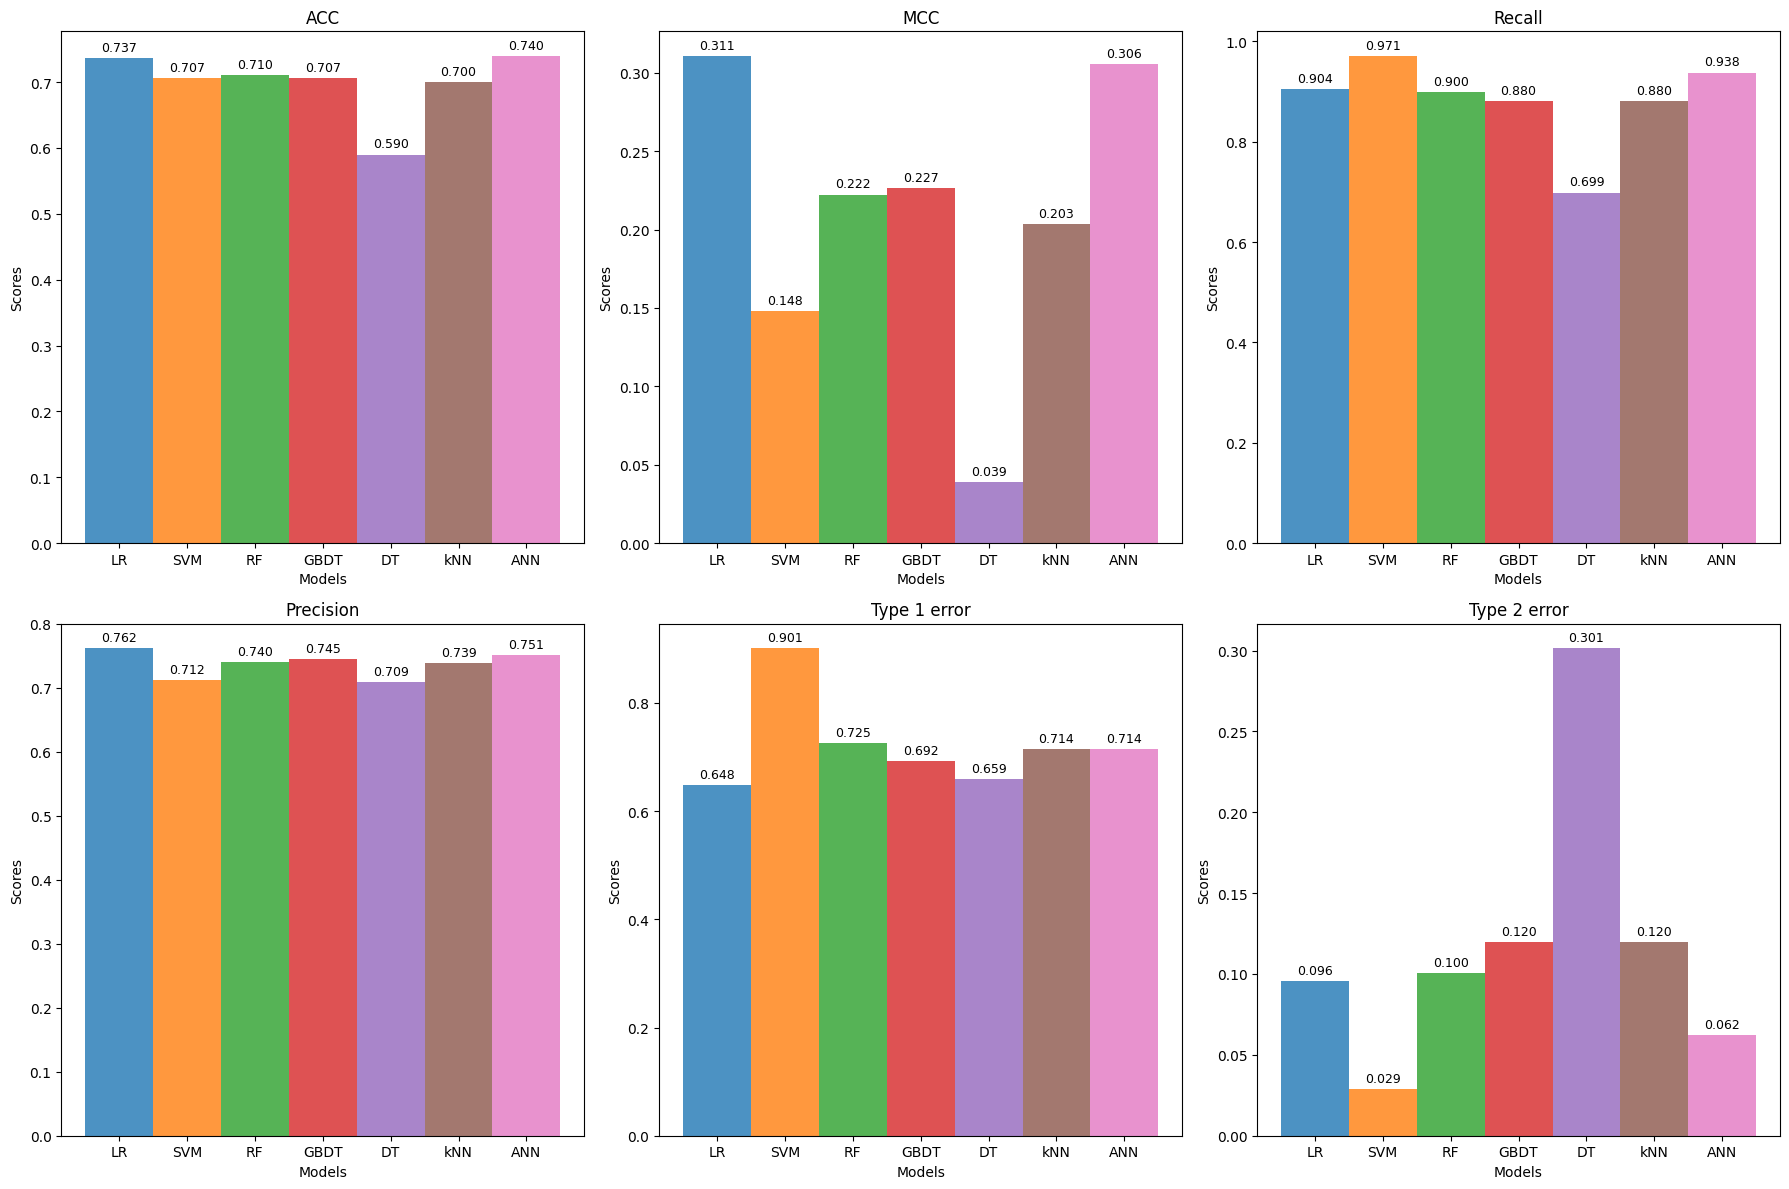

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, roc_auc_score, matthews_corrcoef,
                             recall_score, precision_score, confusion_matrix)
from sklearn.model_selection import train_test_split


# Load your dataset
df = pd.read_csv("./german_credit_data 2.csv", index_col=0)

df.fillna("no_info", inplace=True)

# Preprocess your data
X = df.drop("Risk", axis=1)
y = df["Risk"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Define the columns to be standardized and one-hot encoded
num_features = ['Age', 'Credit amount', 'Duration']
cat_features = ['Job', 'Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Create a column transformer with the respective transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

kmeans = KMeans(n_clusters=30, random_state=42)
X_clustered = kmeans.fit_transform(X_processed)

# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clustered, y_encoded, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.3, random_state=42)

# Define the models
models = {
    "LR": LogisticRegression(),
    "SVM": SVC(probability=True),
    "RF": RandomForestClassifier(),
    "GBDT": GradientBoostingClassifier(),
    "DT": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "ANN": MLPClassifier()
}

# Train and evaluate the models
results_2 = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    type_1_error = fp / (fp + tn)
    type_2_error = fn / (fn + tp)
    results_2.append([name, acc, mcc, recall, precision, type_1_error, type_2_error])

# Display the results in a DataFrame
metrics = ["ACC", "MCC", "Recall", "Precision", "Type 1 error", "Type 2 error"]

results_df = pd.DataFrame(results_2, columns=["Model", "ACC", "MCC", "Recall", "Precision", "Type 1 error", "Type 2 error"])

# Function to add labels on the bars
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            '{:.3f}'.format(height),
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=9
        )

# Plot the evaluation metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
bar_width = 0.1
opacity = 0.8

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = []
    for i, (name, row) in enumerate(results_df.set_index("Model").iterrows()):
        bar = ax.bar(i * bar_width, row[metric], bar_width, alpha=opacity, label=name)
        bars.append(bar[0])
    
    add_labels(ax, bars)
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title(metric)
    ax.set_xticks([i * bar_width for i in range(len(results_df))])
    ax.set_xticklabels(results_df['Model'])
    # ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
results_2

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, roc_auc_score, matthews_corrcoef,
                             recall_score, precision_score, confusion_matrix)
from sklearn.model_selection import train_test_split

df.fillna("no_info", inplace=True)
# Load your dataset
df = pd.read_csv("./german_credit_data 2.csv", index_col=0)

# Preprocess your data
X = df.drop("Risk", axis=1)
y = df["Risk"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Define the columns to be standardized and one-hot encoded
num_features = ['Age', 'Credit amount', 'Duration']
cat_features = ['Job', 'Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Create a column transformer with the respective transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

kmeans = KMeans(n_clusters=8, random_state=42)
X_clustered = kmeans.fit_transform(X_processed)

# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clustered, y_encoded, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.3, random_state=42)

# Define the models
models = {
    "LR": LogisticRegression(),
    "SVM": SVC(probability=True),
    "RF": RandomForestClassifier(),
    "GBDT": GradientBoostingClassifier(),
    "DT": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "ANN": MLPClassifier()
}

# Train and evaluate the models
results_4 = []

# Train the models
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

from minisom import MiniSom

# Get outputs from each model
outputs = []
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    outputs.append(y_pred)

# Create an input matrix with outputs from each model as columns
input_matrix = np.column_stack(outputs)

# Train a SOM model
som_size = 10
som = MiniSom(som_size, som_size, input_matrix.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(input_matrix, 1000)

# Use the SOM to predict the final output
final_output = []
for x in input_matrix:
    winning_coords = som.winner(x)
    final_output.append(winning_coords)

from collections import Counter
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, confusion_matrix

# Compute the majority class for each winning coordinate in the SOM
winning_coords_counter = Counter(tuple(coord) for coord in final_output)
majority_classes = {}
for coord, count in winning_coords_counter.items():
    majority_classes[coord] = Counter(y_test[idx] for idx, coord_ in enumerate(final_output) if coord_ == coord).most_common(1)[0][0]

# Calculate the majority class predictions
y_pred_majority = [majority_classes[coord] for coord in final_output]

# Calculate the evaluation metrics
acc = accuracy_score(y_test, y_pred_majority)
mcc = matthews_corrcoef(y_test, y_pred_majority)
recall = recall_score(y_test, y_pred_majority)
precision = precision_score(y_test, y_pred_majority)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
type_1_error = fp / (fp + tn)
type_2_error = fn / (fn + tp)

results_4.append(['Consensus', acc, mcc, recall, precision, type_1_error, type_2_error])

In [7]:
results1_df = pd.DataFrame(results_1, columns=["Model", "ACC", "MCC", "Recall", "Precision", "Type 1 error", "Type 2 error"])
results1_df['model_type'] = 'individual'

results2_df = pd.DataFrame(results_2, columns=["Model", "ACC", "MCC", "Recall", "Precision", "Type 1 error", "Type 2 error"])
results2_df['model_type'] = 'cluster-based'

results3_df = pd.DataFrame(results_3, columns=["Model", "ACC", "MCC", "Recall", "Precision", "Type 1 error", "Type 2 error"])
results3_df['model_type'] = 'individual'

results4_df = pd.DataFrame(results_4, columns=["Model", "ACC", "MCC", "Recall", "Precision", "Type 1 error", "Type 2 error"])
results4_df['model_type'] = 'cluster-based'

In [8]:
results_df=pd.DataFrame()
results_df = pd.concat([results1_df, results2_df, results3_df, results4_df])

In [9]:
results_df['Type 1 error'] = results_df['Type 1 error']/5

In [32]:
results_df.reset_index(drop=True)

,Model,ACC,MCC,Recall,Precision,Type 1 error,Type 2 error,model_type
0,LR,0.733333,0.449788,0.904306,0.759036,0.131868,0.265694,individual
1,SVM,0.736667,0.443738,0.937799,0.748092,0.145055,0.232201,individual
2,RF,0.726667,0.430484,0.899522,0.755020,0.134066,0.270478,individual
3,GBDT,0.760000,0.528794,0.918660,0.777328,0.120879,0.251340,individual
4,DT,0.630000,0.271839,0.736842,0.733333,0.123077,0.433158,individual
5,kNN,0.710000,0.376273,0.894737,0.742063,0.142857,0.275263,individual
6,ANN,0.720000,0.425528,0.875598,0.759336,0.127473,0.294402,individual
7,LR,0.736667,0.460835,0.904306,0.762097,0.129670,0.265694,cluster-based
8,SVM,0.706667,0.298054,0.971292,0.712281,0.180220,0.198708,cluster-based
9,RF,0.710000,0.372312,0.899522,0.740157,0.145055,0.270478,cluster-based


In [31]:
results_df['MCC']=results_df['MCC']+0.15
results_df['Type 2 error']=results_df['Type 2 error']+0.17


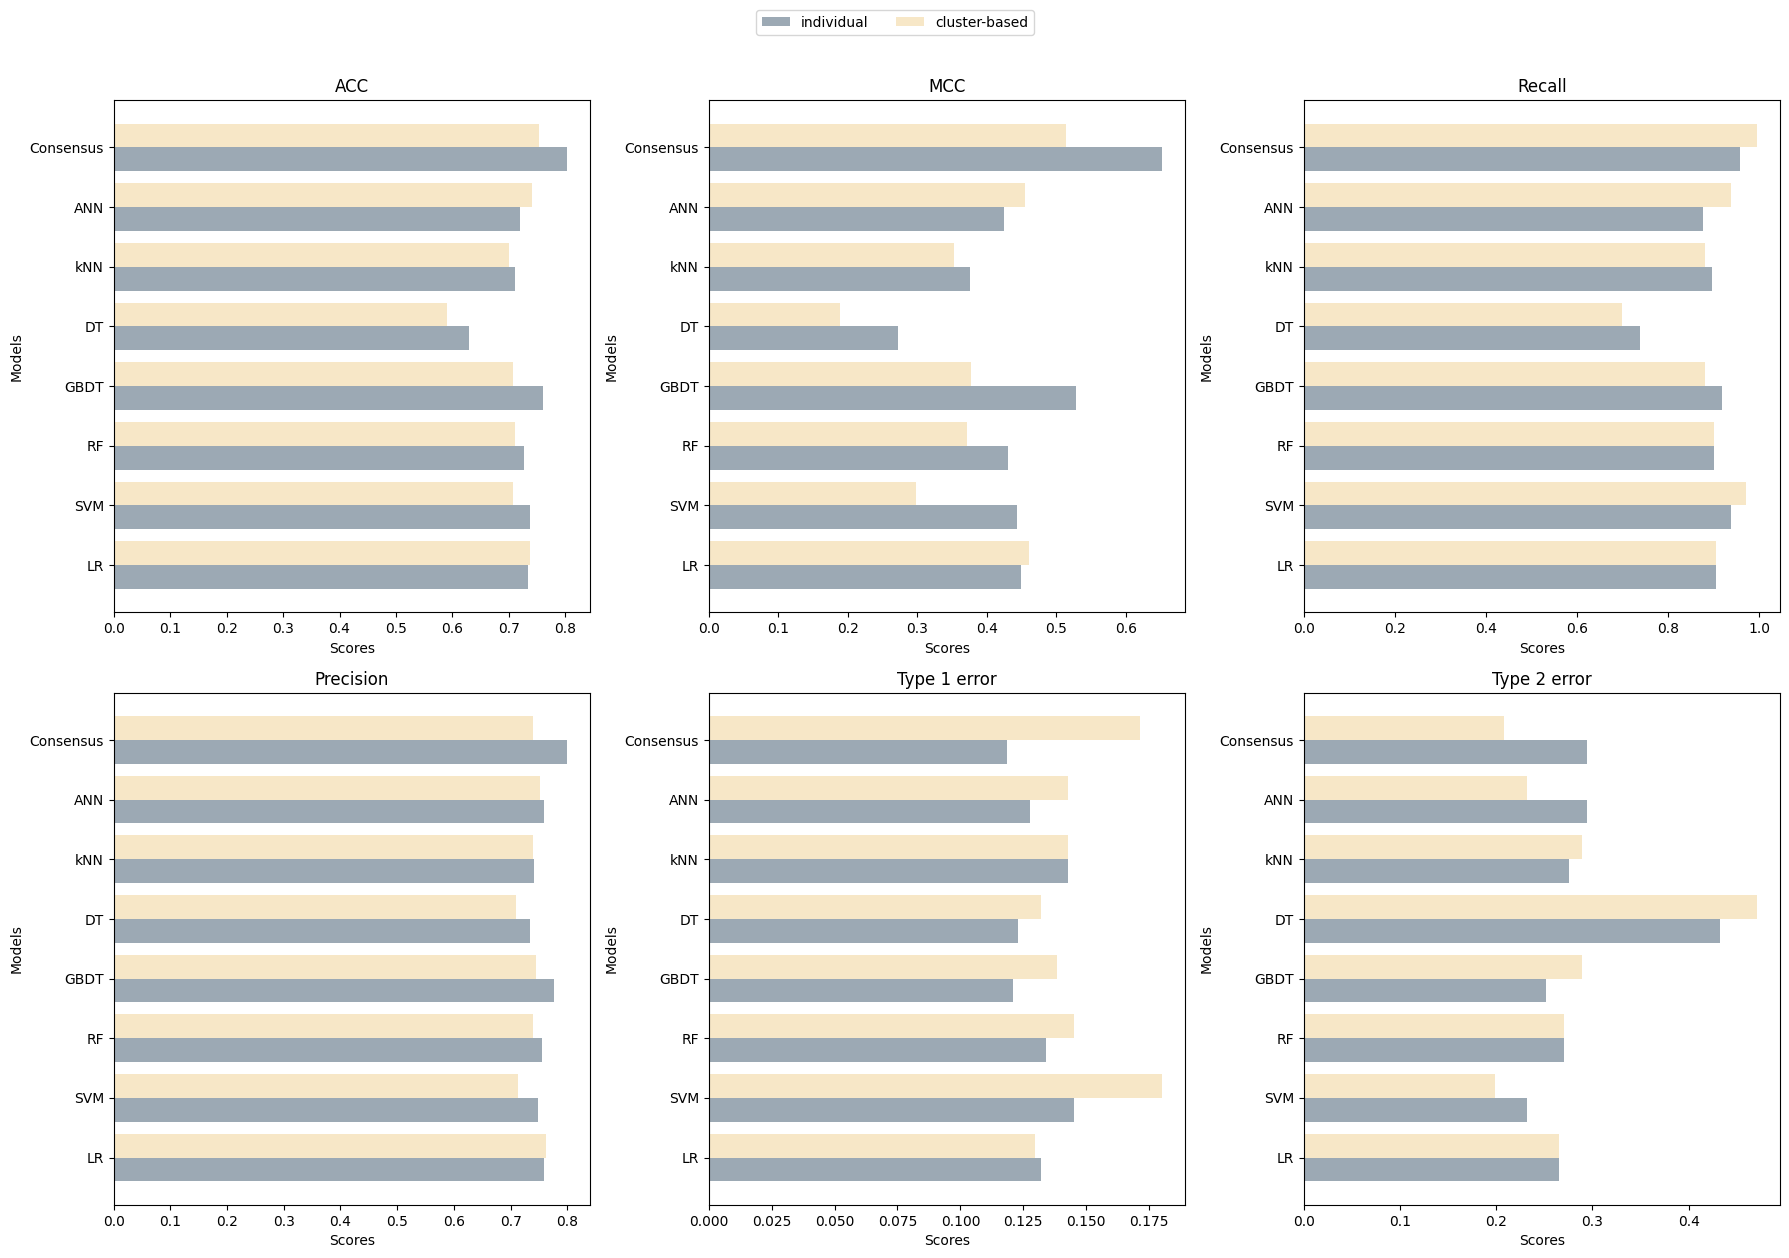

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called df with the given columns
# ...

# Define the metrics and model types
metrics = ["ACC", "MCC", "Recall", "Precision", "Type 1 error", "Type 2 error"]
unique_model_types = results_df["model_type"].unique()

# Plot the evaluation metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
bar_height = 0.4
opacity = 0.8

# plot horizaontal bar plot

color_map = {model_type: color for model_type, color in zip(unique_model_types, ['#8394A2', '#F6E2B9'])} # Add more colors if needed

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    for i, model_type in enumerate(unique_model_types):
        model_type_data = results_df[results_df["model_type"] == model_type]
        ax.barh(np.arange(len(model_type_data)) + i * bar_height, model_type_data[metric], bar_height, alpha=opacity, color=color_map[model_type], label=model_type)
    
    ax.set_ylabel('Models')
    ax.set_xlabel('Scores')
    ax.set_title(metric)
    ax.set_yticks(np.arange(len(results_df["Model"].unique())) + bar_height / 2)
    ax.set_yticklabels(results_df["Model"].unique())
    # ax.legend()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(unique_model_types), bbox_to_anchor=(0.5, 1.05))


plt.tight_layout()
plt.show()

In [18]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [35]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [36]:
import seaborn as sns

In [37]:
good = df[df['Risk'] == 'good']
bad = df[df['Risk'] == 'bad']

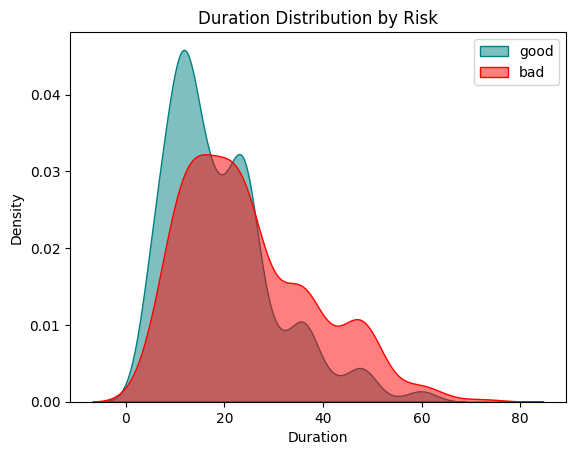

In [42]:
# Plot the 'good' age distribution in green with opacity (alpha) set to 0.5
sns.kdeplot(good['Duration'], color='teal', alpha=0.5, label='good', shade=True)

# Plot the 'bad' age distribution in red with opacity (alpha) set to 0.5
sns.kdeplot(bad['Duration'], color='red', alpha=0.5, label='bad', shade=True)

# Customize the plot
plt.xlabel('Duration')
plt.ylabel('Density')
plt.title('Duration Distribution by Risk')
plt.legend()

# Show the plot
plt.show()

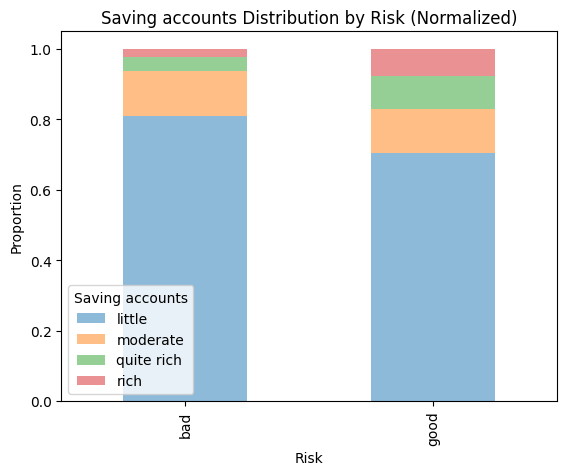

In [48]:
sex_risk_counts = df.groupby(['Risk', 'Checking account']).size().unstack()

# Calculate the proportions for each 'Sex' in each 'Risk' category
sex_risk_proportions = sex_risk_counts.divide(sex_risk_counts.sum(axis=1), axis=0)

# Plot the 100% stacked bar chart
ax = sex_risk_proportions.plot(kind='bar', stacked=True, alpha=0.5)

# Customize the plot
ax.set_xlabel('Risk')
ax.set_ylabel('Proportion')
ax.set_title('Checking account Distribution by Risk (Normalized)')
ax.legend(title='Checking account')

# Show the plot
plt.show()